In [67]:

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# 📈 Backtest Strategy: Options Trading with Composite Spot Signals

## Initial Setup
- **Starting Capital:** ₹200,000  
- **Stop-loss:** 1.5% per trade  
- **Take-profit:** 3% per trade  
- **Force Exit:** 15:15 (local time, IST) if neither stop-loss nor take-profit is hit  

---

## Data Inputs
1. **Spot Signals (`spot_with_signals`)**
   - Contains signals (`Buy` / `Sell`) generated from the composite strategy.
   - Each row has a **unique datetime** (`2023-01-02 09:16:00+05:30`)  
   - Also contains the **spot close price** for that timestamp.
   - Each row includes the **closest expiry date** (e.g. `2023-01-05`).  

2. **Options Data (`df_options_data`)**
   - Includes intraday OHLCV for option contracts.
   - Columns:
     - `datetime` (same format as spot signals, timezone aware: `2023-01-02 09:16:00+05:30`)
     - `expiry_date` (e.g. `2023-01-05`)
     - `strike_price`
     - `option_type` (`CE` = Call, `PE` = Put)
     - `close` (option premium at that timestamp)

---

## Matching Logic
For each row in `spot_with_signals`:

1. **Datetime Match**
   - Select rows in `df_options_data` where  
     `df_options_data["datetime"] == spot_with_signals["datetime"][i]`.

2. **Expiry Match**
   - From the above subset, filter rows where  
     `df_options_data["expiry_date"] == spot_with_signals["closestexpiry"][i]`.

3. **ATM Strike Selection**
   - From the remaining rows, find the strike price **closest** to  
     `spot_with_signals["close"][i]` (spot close price).
   - This identifies the **ATM option contract** for that timestamp.

4. **Direction & Strategy**
   - If **Buy Signal** in `spot_with_signals` → **Sell ATM PUT option** (option_type = `PE`).
   - If **Sell Signal** in `spot_with_signals` → **Sell ATM CALL option** (option_type = `CE`).

5. **Premium Tracking**
   - Record the **option close price** from `df_options_data` (for that ATM strike and expiry).
   - This is used to calculate entry premium and later P&L.

---

## Trade Management
- Each trade has:
  - **Entry price** = option close price at signal time.
  - **Stop-loss:** Exit trade if option price rises **1.5% above entry**.
  - **Take-profit:** Exit trade if option price falls **3% below entry**.
  - **Force Exit:** If neither condition is met, exit trade at **15:15** (EOD close).

---

## Key Notes
- `spot_with_signals["datetime"]` is **unique** for each row.  
- `df_options_data["datetime"]` may contain **multiple rows** per timestamp (different strikes, CE/PE).  
- Matching requires **both datetime and expiry filter** before selecting the **nearest ATM strike**.  
- All datetime values are in format:  

In [68]:
df_options_data= pd.read_parquet('options_data_2023.parquet')

In [4]:
df_options_data.head(10000)

,underlying_symbol,ticker,datetime,expiry_date,strike_price,option_type,open,high,low,close,volume,oi
0,NIFTY,NIFTY29JUN2316000PE,2023-01-02 09:15:00+05:30,2023-06-29,16000.0,PE,111.50,111.50,111.50,111.50,0,0
1,NIFTY,NIFTY29JUN2319000CE,2023-01-02 09:15:00+05:30,2023-06-29,19000.0,CE,457.45,457.45,457.45,457.45,0,0
2,NIFTY,NIFTY29MAR2315000PE,2023-01-02 09:15:00+05:30,2023-03-29,15000.0,PE,26.00,26.00,26.00,26.00,0,0
3,NIFTY,NIFTY29MAR2316000PE,2023-01-02 09:15:00+05:30,2023-03-29,16000.0,PE,46.95,46.95,46.90,46.90,0,0
4,NIFTY,NIFTY29MAR2317000PE,2023-01-02 09:15:00+05:30,2023-03-29,17000.0,PE,135.35,135.35,125.50,130.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NIFTY,NIFTY19JAN2318500CE,2023-01-02 09:44:00+05:30,2023-01-19,18500.0,CE,87.85,91.95,87.85,91.95,0,0
9996,NIFTY,NIFTY19JAN2318600CE,2023-01-02 09:44:00+05:30,2023-01-19,18600.0,CE,60.15,61.10,59.65,61.10,0,0
9997,NIFTY,NIFTY19JAN2318650CE,2023-01-02 09:44:00+05:30,2023-01-19,18650.0,CE,49.55,50.25,49.55,50.25,0,0
9998,NIFTY,NIFTY19JAN2318800CE,2023-01-02 09:44:00+05:30,2023-01-19,18800.0,CE,26.20,27.75,26.20,27.75,0,0


In [42]:
df_options_data.head(10000).to_csv('options_data_2023_head_10000.csv', index=False)

In [5]:
df_options_data.columns

Index(['underlying_symbol', 'ticker', 'datetime', 'expiry_date',
       'strike_price', 'option_type', 'open', 'high', 'low', 'close', 'volume',
       'oi'],
      dtype='object')

In [69]:
spot_with_signals = pd.read_csv('spot_with_signals_2023.csv')

In [7]:
spot_with_signals

,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,tci,wt1,wt2,rsi,cross,signal
0,2023-01-02 09:20:00+05:30,18131.70,18150.15,18117.55,18141.35,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,NaN,Hold
1,2023-01-02 09:21:00+05:30,18142.20,18145.70,18131.40,18135.65,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,NaN,Hold
2,2023-01-02 09:22:00+05:30,18133.25,18140.55,18120.65,18140.55,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,NaN,Hold
3,2023-01-02 09:23:00+05:30,18139.40,18139.40,18120.15,18130.75,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,NaN,Hold
4,2023-01-02 09:24:00+05:30,18130.30,18133.55,18113.05,18113.10,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,NaN,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90877,2023-12-29 15:26:00+05:30,21711.85,21725.75,21711.30,21725.35,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90878,2023-12-29 15:27:00+05:30,21725.80,21725.95,21723.25,21724.45,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90879,2023-12-29 15:28:00+05:30,21724.45,21724.45,21713.90,21723.40,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90880,2023-12-29 15:29:00+05:30,21722.10,21725.00,21720.10,21723.65,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold


In [8]:
spot_with_signals['cross'].isna().sum()

np.int64(77281)

In [29]:
spot_with_signals[spot_with_signals['cross'].notna()]

,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,tci,wt1,wt2,rsi,cross,signal,signal_encoded
125,2023-01-02 11:25:00+05:30,18191.15,18192.45,18189.45,18190.05,2023-01-05,18186.58,18183.01,9.44,25.21,42.06,42.06,43.34,55.02,43.34,Sell,-1
126,2023-01-02 11:26:00+05:30,18189.85,18192.45,18189.45,18190.50,2023-01-05,18186.58,18183.01,9.44,25.21,42.06,42.06,43.34,55.02,43.34,Hold,0
127,2023-01-02 11:27:00+05:30,18188.80,18191.05,18187.70,18189.45,2023-01-05,18186.58,18183.01,9.44,25.21,42.06,42.06,43.34,55.02,43.34,Hold,0
128,2023-01-02 11:28:00+05:30,18189.35,18189.40,18187.25,18187.40,2023-01-05,18186.58,18183.01,9.44,25.21,42.06,42.06,43.34,55.02,43.34,Hold,0
129,2023-01-02 11:29:00+05:30,18187.00,18187.45,18183.60,18183.70,2023-01-05,18186.58,18183.01,9.44,25.21,42.06,42.06,43.34,55.02,43.34,Hold,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90877,2023-12-29 15:26:00+05:30,21711.85,21725.75,21711.30,21725.35,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0
90878,2023-12-29 15:27:00+05:30,21725.80,21725.95,21723.25,21724.45,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0
90879,2023-12-29 15:28:00+05:30,21724.45,21724.45,21713.90,21723.40,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0
90880,2023-12-29 15:29:00+05:30,21722.10,21725.00,21720.10,21723.65,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0


In [38]:
spot_with_signals['cross'].fillna(0)

0         0.00
1         0.00
2         0.00
3         0.00
4         0.00
         ...  
90877    10.06
90878    10.06
90879    10.06
90880    10.06
90881    10.53
Name: cross, Length: 90882, dtype: float64

In [70]:
spot_with_signals['cross'] = spot_with_signals['cross'].fillna(0)
spot_with_signals

,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,tci,wt1,wt2,rsi,cross,signal
0,2023-01-02 09:20:00+05:30,18131.70,18150.15,18117.55,18141.35,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold
1,2023-01-02 09:21:00+05:30,18142.20,18145.70,18131.40,18135.65,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold
2,2023-01-02 09:22:00+05:30,18133.25,18140.55,18120.65,18140.55,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold
3,2023-01-02 09:23:00+05:30,18139.40,18139.40,18120.15,18130.75,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold
4,2023-01-02 09:24:00+05:30,18130.30,18133.55,18113.05,18113.10,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90877,2023-12-29 15:26:00+05:30,21711.85,21725.75,21711.30,21725.35,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90878,2023-12-29 15:27:00+05:30,21725.80,21725.95,21723.25,21724.45,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90879,2023-12-29 15:28:00+05:30,21724.45,21724.45,21713.90,21723.40,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold
90880,2023-12-29 15:29:00+05:30,21722.10,21725.00,21720.10,21723.65,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold


In [10]:
spot_with_signals['signal'].unique()
counts = spot_with_signals['signal'].value_counts()
print(counts)

signal
Hold    88125
Buy      1386
Sell     1371
Name: count, dtype: int64


<Axes: >

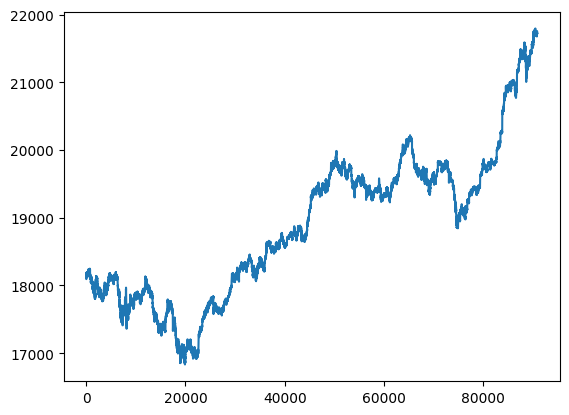

In [11]:
spot_with_signals['close'].plot()

In [71]:
import matplotlib.pyplot as plt
mapping = {'Hold': 0, 'Buy': 1, 'Sell': -1}
spot_with_signals['signal_encoded'] = spot_with_signals['signal'].map(mapping)


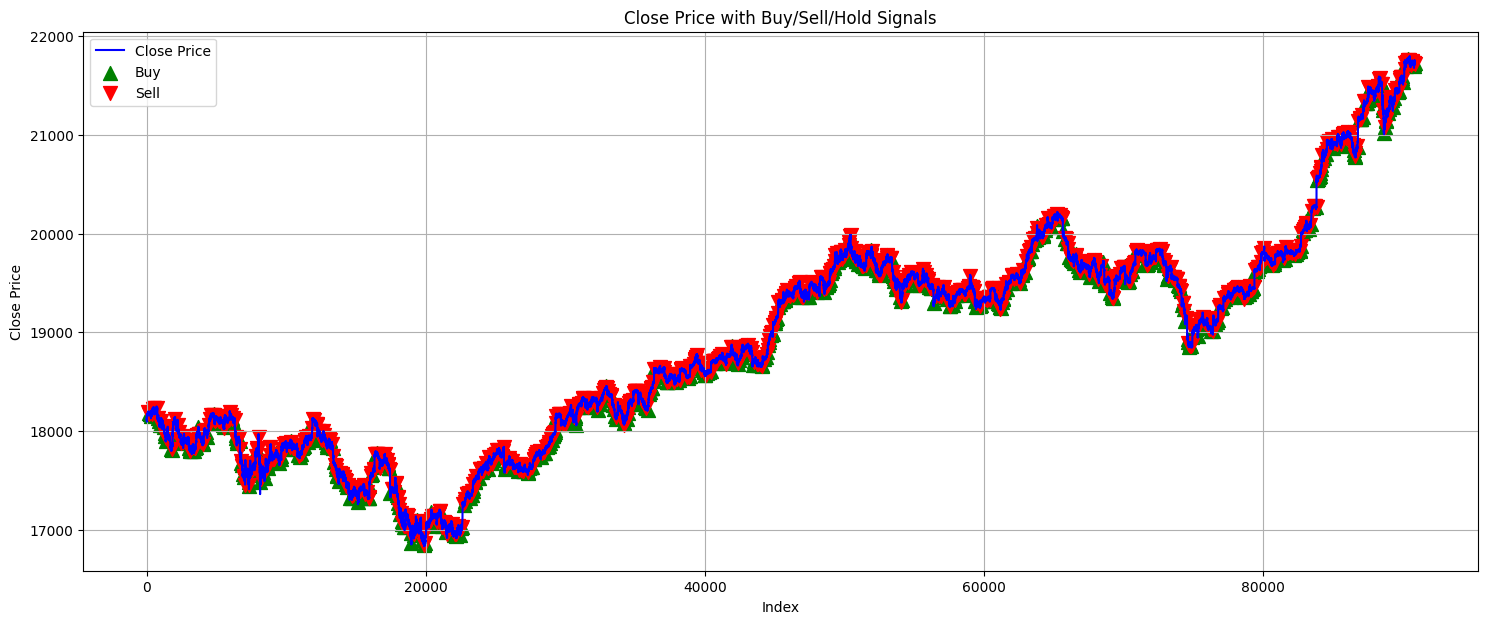

In [72]:
import matplotlib.pyplot as plt
mapping = {'Hold': 0, 'Buy': 1, 'Sell': -1}
spot_with_signals['signal_encoded'] = spot_with_signals['signal'].map(mapping)
plt.figure(figsize=(18,7))
plt.plot(spot_with_signals['close'], label='Close Price', color='blue')
plt.scatter(
    spot_with_signals.index[spot_with_signals['signal_encoded'] == 1],
    spot_with_signals['close'][spot_with_signals['signal_encoded'] == 1],
    label='Buy',
    marker='^',
    color='green',
    s=100
)
plt.scatter(
    spot_with_signals.index[spot_with_signals['signal_encoded'] == -1],
    spot_with_signals['close'][spot_with_signals['signal_encoded'] == -1],
    label='Sell',
    marker='v',
    color='red',
    s=100
)
plt.title('Close Price with Buy/Sell/Hold Signals')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Basic ML XGboost Strategy

In [73]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
df=spot_with_signals.copy()
df['returns'] = df['close'].pct_change().shift(-1)
features = ['ap','esa','d','ci','tci','wt1','wt2','rsi','cross','signal_encoded']
X = df[features].dropna()
y = np.where(df['returns'].loc[X.index] > 0, 1, 0)   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5541068383121527
[[4979 3996]
 [4109 5093]]


In [74]:
def indicator_vote(row):
    votes = []
    if row['rsi'] > 70: votes.append(-1)
    elif row['rsi'] < 30: votes.append(1)
    votes.append(row['cross'])  # assuming -1/0/1
    return np.sign(np.sum(votes)) if votes else 0
df['ml_signal'] = model.predict(X)
df['ind_signal'] = df.apply(indicator_vote, axis=1)
df['composite_score'] = (
    0.5*df['signal_encoded'] +
    0.3*df['ml_signal'] +
    0.2*df['ind_signal']
)
df['composite_signal'] = df['composite_score'].apply(
    lambda x: 'Buy' if x>=0.4 else ('Sell' if x<=-0.4 else 'Hold')
)
df['composite_signal']

0        Hold
1        Hold
2        Hold
3        Hold
4        Hold
         ... 
90877     Buy
90878     Buy
90879     Buy
90880     Buy
90881     Buy
Name: composite_signal, Length: 90882, dtype: object

In [75]:
import numpy as np, pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
df = spot_with_signals.copy()
H = 3 
fwd_ret = df['close'].pct_change(H).shift(-H)
eps = 0.0003  
y_full = np.where(fwd_ret > eps, 1, np.where(fwd_ret < -eps, 0, np.nan))
base_feats = ['ap','esa','d','ci','tci','wt1','wt2'
              
              
              ,'rsi','cross','signal_encoded',
              'open','high','low','close']
df['ret1'] = df['close'].pct_change(1)
df['ret3'] = df['close'].pct_change(3)
df['hl_range'] = (df['high'] - df['low']) / df['close'].shift(1)
df['body'] = (df['close'] - df['open']) / df['open']

for c in ['ap','esa','d','ci','tci','wt1','wt2','rsi','cross','ret1','ret3','hl_range','body','signal_encoded']:
    df[f'{c}_lag1'] = df[c].shift(1)
roll_cols = ['rsi','wt1','wt2','ret1','hl_range','body']
for c in roll_cols:
    df[f'{c}_r3'] = df[c].shift(1).rolling(3).mean()
    df[f'{c}_r5'] = df[c].shift(1).rolling(5, min_periods=3).mean() 
    df[f'{c}_s5']  = df[c].shift(1).rolling(5, min_periods=3).std()
df['wt_diff_lag1'] = (df['wt1'] - df['wt2']).shift(1)

# ATR-like (minimal)
tr = np.maximum(df['high']-df['low'],
                np.maximum((df['high']-df['close'].shift(1)).abs(),
                           (df['low']-df['close'].shift(1)).abs()))
df['atr5'] = tr.shift(1).rolling(5).mean()
df['atr5_n'] = df['atr5'] / df['close'].shift(1)

# final feature list
feat_cols = [c for c in df.columns if any(s in c for s in
              ['ap','esa','d','ci','tci','wt','rsi','cross','ret','hl_range','body','lag1','r3','r5','s5','wt_diff','atr5_n','signal_encoded'])
             and not c.endswith(('open','high','low','close'))]

X_full = df[feat_cols]
data = pd.concat([X_full, pd.Series(y_full, name='y')], axis=1).dropna()
X_full = data[feat_cols]
y_full = data['y'].astype(int)

# ----------------------------
n = len(X_full)
test_size = int(0.2 * n)
val_size = int(0.1 * n)  
X_train_all = X_full.iloc[:n - test_size]
y_train_all = y_full.iloc[:n - test_size]
X_test = X_full.iloc[n - test_size:]
y_test = y_full.iloc[n - test_size:]
X_train = X_train_all.iloc[:-val_size]
y_train = y_train_all.iloc[:-val_size]
X_val = X_train_all.iloc[-val_size:]
y_val = y_train_all.iloc[-val_size:]
for name in ["datetime", "closest_expiry"]:
    for X_ in [X_train, X_val, X_test]:
        if name in X_.columns:
            X_.drop(columns=[name], inplace=True)
drop_cols = ["datetime", "closest_expiry"]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns]).copy()
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns]).copy()
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns]).copy()
X_train = X_train.select_dtypes(include=[np.number])
X_val   = X_val.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])
X_train_ = X_train.astype(float)
X_val_   = X_val.astype(float)
X_test_  = X_test.astype(float)

dtrain = xgb.DMatrix(X_train_, label=y_train)
dval   = xgb.DMatrix(X_val_,   label=y_val)
dtest  = xgb.DMatrix(X_test_,  label=y_test)

pos_ratio = y_train.mean()
neg_ratio = 1 - pos_ratio
scale_pos_weight = (neg_ratio / max(pos_ratio, 1e-6))
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.03,              
    'max_depth': 5,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 2.0,               # reg_lambda
    'alpha': 0.0,                # reg_alpha
    'tree_method': 'hist',
    'seed': 42,
    'scale_pos_weight': float(scale_pos_weight),
    'verbosity': 0
}
num_boost_round = 2000
early_stopping_rounds = 150

watchlist = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)
def predict_with_best(bst, dmat):
    try:
        # Newer xgb
        return bst.predict(dmat, iteration_range=(0, bst.best_iteration + 1))
    except TypeError:
        # Older xgb
        return bst.predict(dmat, ntree_limit=bst.best_ntree_limit)

p_val  = predict_with_best(bst, dval)
p_test = predict_with_best(bst, dtest)

thr_grid = np.linspace(0.3, 0.7, 81)
best_thr, best_acc = 0.5, -1
for thr in thr_grid:
    acc = accuracy_score(y_val, (p_val >= thr).astype(int))
    if acc > best_acc:
        best_acc, best_thr = acc, thr

y_pred = (p_test >= best_thr).astype(int)

print(f"Chosen threshold on val: {best_thr:.3f} (val acc={best_acc:.4f})")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# ----------------------------
# 8) Produce composite signal (optional)
# ----------------------------
# ML vote in {-1, +1}
ml_vote = np.where(p_test >= best_thr, 1, -1)

# Indicator vote (example: RSI & cross)
def indicator_vote_row(row):
    votes = []
    # RSI
    if row['rsi'] > 70: votes.append(-1)
    elif row['rsi'] < 30: votes.append(1)
    # cross already in {-1,0,1} ideally; if not, clamp
    cross_v = np.sign(row['cross']) if pd.notna(row['cross']) else 0
    votes.append(int(cross_v))
    s = np.sign(np.sum(votes)) if votes else 0
    return int(s if s != 0 else 0)

ind_vote = df.iloc[X_test.index].apply(indicator_vote_row, axis=1).values

signal_core = df.loc[X_test.index, 'signal_encoded'].clip(-1,1).fillna(0).values.astype(int)

comp_score = 0.5*signal_core + 0.3*ml_vote + 0.2*ind_vote
comp_sig = np.where(comp_score >= 0.4, 'Buy', np.where(comp_score <= -0.4, 'Sell', 'Hold'))

# Attach to a result frame if you want to backtest:
out = pd.DataFrame({
    'datetime': df.loc[X_test.index, 'datetime'].values if 'datetime' in df.columns else X_test.index,
    'y_true': y_test.values,
    'proba': p_test,
    'ml_vote': ml_vote,
    'ind_vote': ind_vote,
    'signal_core': signal_core,
    'composite_score': comp_score,
    'composite_signal': comp_sig
})


Chosen threshold on val: 0.520 (val acc=0.8193)
Test Accuracy: 0.7996119733924612
[[2603  820]
 [ 626 3167]]
              precision    recall  f1-score   support

           0     0.8061    0.7604    0.7826      3423
           1     0.7943    0.8350    0.8141      3793

    accuracy                         0.7996      7216
   macro avg     0.8002    0.7977    0.7984      7216
weighted avg     0.7999    0.7996    0.7992      7216



In [78]:
# 8.1 Predict probabilities for ALL rows in X_full
X_all_ = X_full.select_dtypes(include=[np.number]).astype(float)
dall = xgb.DMatrix(X_all_, label=y_full)
p_all = predict_with_best(bst, dall)   # uses best_iteration

# 8.2 ML vote for all rows using the tuned threshold
ml_vote_all = np.where(p_all >= best_thr, 1, -1)

# 8.3 Indicator vote (example: RSI + cross) for all rows aligned to X_full indices
def indicator_vote_row(row):
    votes = []
    # RSI (mean-reversion)
    if pd.notna(row.get('rsi', np.nan)):
        if row['rsi'] > 70: votes.append(-1)
        elif row['rsi'] < 30: votes.append(1)
    # CROSS (assumed positive = buy, negative = sell)
    cross_v = row.get('cross', 0)
    if pd.notna(cross_v):
        votes.append(int(np.sign(cross_v)))
    s = np.sign(np.sum(votes)) if votes else 0
    return int(s) if s != 0 else 0
ml_proba_scored = pd.Series(p_all, index=X_full.index)
ml_vote_scored  = pd.Series(ml_vote_all, index=X_full.index)
ml_proba_full = ml_proba_scored.reindex(df.index).fillna(0.5)     # neutral prob
ml_vote_full  = ml_vote_scored.reindex(df.index).fillna(0).astype(int)

# Indicator vote for ALL rows (function handles NaNs → 0)
indicator_vote_full = df.apply(indicator_vote_row, axis=1).fillna(0).astype(int)

# Core in-house signal for ALL rows
signal_core_full = (
    df.get('signal_encoded', pd.Series(0, index=df.index))
      .clip(-1, 1).fillna(0).astype(int)
)

# 3) Composite score & label for ALL rows
w_core, w_ml, w_ind = 0.5, 0.3, 0.2
comp_score_full = w_core*signal_core_full + w_ml*ml_vote_full + w_ind*indicator_vote_full
comp_num_full   = np.where(comp_score_full >= 0.4, 1,
                    np.where(comp_score_full <= -0.4, -1, 0))
comp_lbl_full   = pd.Series(comp_num_full, index=df.index).map({1:'Buy', -1:'Sell', 0:'Hold'})

# 4) Assign back (no NaNs now)
df = df.assign(
    ml_proba=ml_proba_full,
    ml_vote=ml_vote_full,
    indicator_vote=indicator_vote_full,
    signal_core=signal_core_full,
    composite_score=comp_score_full,
    composite_signal_num=comp_num_full,
    composite_signal=comp_lbl_full
)

df

,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,...,wt_diff_lag1,atr5,atr5_n,ml_proba,ml_vote,indicator_vote,signal_core,composite_score,composite_signal_num,composite_signal
0,2023-01-02 09:20:00+05:30,18131.70,18150.15,18117.55,18141.35,2023-01-05,18125.43,18129.07,23.75,-10.22,...,NaN,NaN,NaN,0.5,0,0,0,0.0,0,Hold
1,2023-01-02 09:21:00+05:30,18142.20,18145.70,18131.40,18135.65,2023-01-05,18125.43,18129.07,23.75,-10.22,...,4.39,NaN,NaN,0.5,0,0,0,0.0,0,Hold
2,2023-01-02 09:22:00+05:30,18133.25,18140.55,18120.65,18140.55,2023-01-05,18125.43,18129.07,23.75,-10.22,...,4.39,NaN,NaN,0.5,0,0,0,0.0,0,Hold
3,2023-01-02 09:23:00+05:30,18139.40,18139.40,18120.15,18130.75,2023-01-05,18125.43,18129.07,23.75,-10.22,...,4.39,NaN,NaN,0.5,0,0,0,0.0,0,Hold
4,2023-01-02 09:24:00+05:30,18130.30,18133.55,18113.05,18113.10,2023-01-05,18125.43,18129.07,23.75,-10.22,...,4.39,NaN,NaN,0.5,0,0,0,0.0,0,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90877,2023-12-29 15:26:00+05:30,21711.85,21725.75,21711.30,21725.35,2024-01-04,21720.30,21722.18,7.94,-15.79,...,-1.72,9.88,0.000455,0.5,0,1,0,0.2,0,Hold
90878,2023-12-29 15:27:00+05:30,21725.80,21725.95,21723.25,21724.45,2024-01-04,21720.30,21722.18,7.94,-15.79,...,-1.72,11.26,0.000518,0.5,0,1,0,0.2,0,Hold
90879,2023-12-29 15:28:00+05:30,21724.45,21724.45,21713.90,21723.40,2024-01-04,21720.30,21722.18,7.94,-15.79,...,-1.72,9.66,0.000445,0.5,0,1,0,0.2,0,Hold
90880,2023-12-29 15:29:00+05:30,21722.10,21725.00,21720.10,21723.65,2024-01-04,21720.30,21722.18,7.94,-15.79,...,-1.72,10.02,0.000461,0.5,0,1,0,0.2,0,Hold


In [79]:
spot_with_signals['composite_signal'] = df['composite_signal']


In [58]:
df_options_data

,underlying_symbol,ticker,datetime,expiry_date,strike_price,option_type,open,high,low,close,volume,oi
0,NIFTY,NIFTY29JUN2316000PE,2023-01-02 09:15:00+05:30,2023-06-29,16000.0,PE,111.50,111.50,111.50,111.50,0,0
1,NIFTY,NIFTY29JUN2319000CE,2023-01-02 09:15:00+05:30,2023-06-29,19000.0,CE,457.45,457.45,457.45,457.45,0,0
2,NIFTY,NIFTY29MAR2315000PE,2023-01-02 09:15:00+05:30,2023-03-29,15000.0,PE,26.00,26.00,26.00,26.00,0,0
3,NIFTY,NIFTY29MAR2316000PE,2023-01-02 09:15:00+05:30,2023-03-29,16000.0,PE,46.95,46.95,46.90,46.90,0,0
4,NIFTY,NIFTY29MAR2317000PE,2023-01-02 09:15:00+05:30,2023-03-29,17000.0,PE,135.35,135.35,125.50,130.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42146257,NIFTY,NIFTY2410423150CE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,CE,0.95,1.00,0.95,0.95,0,0
42146258,NIFTY,NIFTY2410423150PE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,PE,1363.40,1363.40,1363.40,1363.40,0,0
42146259,NIFTY,NIFTY2410423200CE,2023-12-29 15:29:00+05:30,2024-01-04,23200.0,CE,0.95,1.00,0.95,0.95,0,0
42146260,NIFTY,NIFTY2410423250CE,2023-12-29 15:29:00+05:30,2024-01-04,23250.0,CE,0.95,0.95,0.90,0.95,0,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def prepare_features(X, ref_cols=None, drop_cols=("datetime", "closest_expiry")):
    Xc = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore").copy()
    
    # Keep numeric only
    Xc = Xc.select_dtypes(include=[np.number]).copy()
    
    # Align column order if reference cols provided
    if ref_cols is not None:
        Xc = Xc.reindex(columns=ref_cols, fill_value=np.nan).copy()
    
    # Replace infinities
    Xc = Xc.replace([np.inf, -np.inf], np.nan)
    
    return Xc

X_train = prepare_features(X_train)
X_val   = prepare_features(X_val, ref_cols=X_train.columns)
X_test  = prepare_features(X_test, ref_cols=X_train.columns)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.03,
    "max_depth": 5,
    "min_child_weight": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "tree_method": "hist",
    "seed": 42,
    "scale_pos_weight": float(scale_pos_weight),
    "verbosity": 0
}

num_boost_round = 2000
early_stopping_rounds = 150

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)
p_val  = bst.predict(dval,  iteration_range=(0, bst.best_iteration + 1))
p_test = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

# Threshold tuning
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr, best_acc = 0.5, -1
for thr in thr_grid:
    acc = accuracy_score(y_val, (p_val >= thr).astype(int))
    if acc > best_acc:
        best_acc, best_thr = acc, thr

y_pred = (p_test >= best_thr).astype(int)

print(f"Chosen threshold: {best_thr:.3f} (val acc={best_acc:.4f})")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))



Chosen threshold: 0.520 (val acc=0.8193)
Test Accuracy: 0.7996119733924612
[[2603  820]
 [ 626 3167]]
              precision    recall  f1-score   support

           0     0.8061    0.7604    0.7826      3423
           1     0.7943    0.8350    0.8141      3793

    accuracy                         0.7996      7216
   macro avg     0.8002    0.7977    0.7984      7216
weighted avg     0.7999    0.7996    0.7992      7216



In [62]:
for name in ["datetime", "closest_expiry"]:
    for X_ in [X_train, X_val, X_test]:
        if name in X_.columns:
            X_.drop(columns=[name], inplace=True)

# 2) Keep only numeric dtypes
drop_cols = ["datetime", "closest_expiry"]

X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns]).copy()
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns]).copy()
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns]).copy()

# Keep only numeric dtypes
X_train = X_train.select_dtypes(include=[np.number])
X_val   = X_val.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])

# Align column order
cols = X_train.columns.tolist()
X_val  = X_val.reindex(columns=cols, fill_value=np.nan)
X_test = X_test.reindex(columns=cols, fill_value=np.nan)
X_train = X_train.select_dtypes(include=[np.number]).copy()
X_val   = X_val.select_dtypes(include=[np.number]).copy()
X_test  = X_test.select_dtypes(include=[np.number]).copy()
X_train_ = X_train.astype(float)
X_val_   = X_val.astype(float)
X_test_  = X_test.astype(float)

dtrain = xgb.DMatrix(X_train_, label=y_train)
dval   = xgb.DMatrix(X_val_,   label=y_val)
dtest  = xgb.DMatrix(X_test_,  label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.03,                 # learning_rate
    'max_depth': 5,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 2.0,               # reg_lambda
    'alpha': 0.0,                # reg_alpha
    'tree_method': 'hist',
    'seed': 42,
    'scale_pos_weight': float(scale_pos_weight),
    'verbosity': 0
}

num_boost_round = 2000
early_stopping_rounds = 150

watchlist = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)

# --- Probabilities with best iteration (compat across versions) ---
def predict_with_best(bst, dmat):
    try:
        # Newer xgb
        return bst.predict(dmat, iteration_range=(0, bst.best_iteration + 1))
    except TypeError:
        # Older xgb
        return bst.predict(dmat, ntree_limit=bst.best_ntree_limit)

p_val  = predict_with_best(bst, dval)
p_test = predict_with_best(bst, dtest)

# --- Threshold tuning on validation ---
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr, best_acc = 0.5, -1
for thr in thr_grid:
    acc = accuracy_score(y_val, (p_val >= thr).astype(int))
    if acc > best_acc:
        best_acc, best_thr = acc, thr

y_pred = (p_test >= best_thr).astype(int)

print(f"Chosen threshold on val: {best_thr:.3f} (val acc={best_acc:.4f})")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Chosen threshold on val: 0.520 (val acc=0.8193)
Test Accuracy: 0.7996119733924612
[[2603  820]
 [ 626 3167]]
              precision    recall  f1-score   support

           0     0.8061    0.7604    0.7826      3423
           1     0.7943    0.8350    0.8141      3793

    accuracy                         0.7996      7216
   macro avg     0.8002    0.7977    0.7984      7216
weighted avg     0.7999    0.7996    0.7992      7216



In [80]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train.astype(float), label=y_train)
dval   = xgb.DMatrix(X_val.astype(float),   label=y_val)
dtest  = xgb.DMatrix(X_test.astype(float),  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.03,
    "max_depth": 5,
    "min_child_weight": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "alpha": 0.0,
    "tree_method": "hist",
    "seed": 42,
    "scale_pos_weight": float(scale_pos_weight),
    "verbosity": 0
}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain,"train"), (dval,"val")],
    early_stopping_rounds=150,
    verbose_eval=False
)

p_val  = bst.predict(dval,  iteration_range=(0, bst.best_iteration + 1))
p_test = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))


In [81]:
spot_with_signals


,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,tci,wt1,wt2,rsi,cross,signal,signal_encoded,composite_signal
0,2023-01-02 09:20:00+05:30,18131.70,18150.15,18117.55,18141.35,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold,0,Hold
1,2023-01-02 09:21:00+05:30,18142.20,18145.70,18131.40,18135.65,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold,0,Hold
2,2023-01-02 09:22:00+05:30,18133.25,18140.55,18120.65,18140.55,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold,0,Hold
3,2023-01-02 09:23:00+05:30,18139.40,18139.40,18120.15,18130.75,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold,0,Hold
4,2023-01-02 09:24:00+05:30,18130.30,18133.55,18113.05,18113.10,2023-01-05,18125.43,18129.07,23.75,-10.22,-53.39,-53.39,-57.78,39.45,0.00,Hold,0,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90877,2023-12-29 15:26:00+05:30,21711.85,21725.75,21711.30,21725.35,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0,Hold
90878,2023-12-29 15:27:00+05:30,21725.80,21725.95,21723.25,21724.45,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0,Hold
90879,2023-12-29 15:28:00+05:30,21724.45,21724.45,21713.90,21723.40,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0,Hold
90880,2023-12-29 15:29:00+05:30,21722.10,21725.00,21720.10,21723.65,2024-01-04,21720.30,21722.18,7.94,-15.79,8.34,8.34,10.06,52.04,10.06,Hold,0,Hold


In [82]:
df_options_data['expiry_date'] = pd.to_datetime(df_options_data['expiry_date'])
df_options_data['expiry_date']=df_options_data['expiry_date'].dt.date
df_options_data
    

,underlying_symbol,ticker,datetime,expiry_date,strike_price,option_type,open,high,low,close,volume,oi
0,NIFTY,NIFTY29JUN2316000PE,2023-01-02 09:15:00+05:30,2023-06-29,16000.0,PE,111.50,111.50,111.50,111.50,0,0
1,NIFTY,NIFTY29JUN2319000CE,2023-01-02 09:15:00+05:30,2023-06-29,19000.0,CE,457.45,457.45,457.45,457.45,0,0
2,NIFTY,NIFTY29MAR2315000PE,2023-01-02 09:15:00+05:30,2023-03-29,15000.0,PE,26.00,26.00,26.00,26.00,0,0
3,NIFTY,NIFTY29MAR2316000PE,2023-01-02 09:15:00+05:30,2023-03-29,16000.0,PE,46.95,46.95,46.90,46.90,0,0
4,NIFTY,NIFTY29MAR2317000PE,2023-01-02 09:15:00+05:30,2023-03-29,17000.0,PE,135.35,135.35,125.50,130.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42146257,NIFTY,NIFTY2410423150CE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,CE,0.95,1.00,0.95,0.95,0,0
42146258,NIFTY,NIFTY2410423150PE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,PE,1363.40,1363.40,1363.40,1363.40,0,0
42146259,NIFTY,NIFTY2410423200CE,2023-12-29 15:29:00+05:30,2024-01-04,23200.0,CE,0.95,1.00,0.95,0.95,0,0
42146260,NIFTY,NIFTY2410423250CE,2023-12-29 15:29:00+05:30,2024-01-04,23250.0,CE,0.95,0.95,0.90,0.95,0,0


Initial Capital:    ₹200,000
Final Capital:      ₹5,223,126
Total P&L:          ₹5,023,126.40
Total Return:       2511.56%

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')
from strategy_ml import spot_with_signals
from strategy_ml import df_options_data
class OptionsBacktest:
    def __init__(self, initial_capital=200000, stop_loss_pct=1.5, take_profit_pct=3.0):
        self.initial_capital = initial_capital
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.force_exit_time = time(15, 15)  # 15:15 IST
        
        # Track portfolio metrics
        self.capital = initial_capital
        self.trades = []
        self.portfolio_value = []
        
    def find_atm_option(self, df_options, datetime_val, expiry_date, spot_price, option_type):

        # Filter options for the specific datetime and expiry
        mask = (
            (df_options['datetime'] == datetime_val) & 
            (df_options['expiry_date'] == expiry_date) &
            (df_options['option_type'] == option_type)
        )
        filtered_options = df_options[mask]
        
        if filtered_options.empty:
            return None
            
        # Find the strike closest to spot price (ATM)
        filtered_options['strike_diff'] = abs(filtered_options['strike_price'] - spot_price)
        atm_option = filtered_options.loc[filtered_options['strike_diff'].idxmin()]
        
        return atm_option
    
    def calculate_pnl(self, entry_price, exit_price, option_type, lot_size=1):
     
        # For selling options: profit when option premium decreases
        pnl = (entry_price - exit_price) * lot_size
        return pnl
    
    def check_exit_conditions(self, entry_price, current_price, current_time):
        # Calculate current P&L percentage
        # For selling: profit when price goes down
        pnl_pct = ((entry_price - current_price) / entry_price) * 100
        
        # Check stop loss (loss when option price increases)
        if pnl_pct <= -self.stop_loss_pct:
            return True, 'stop_loss'
        
        # Check take profit (profit when option price decreases)
        if pnl_pct >= self.take_profit_pct:
            return True, 'take_profit'
        
        # Check force exit time
        if current_time.time() >= self.force_exit_time:
            return True, 'force_exit'
        
        return False, None
    
    def run_backtest(self, spot_with_signals, df_options_data):
        print(f"Starting Backtest with Initial Capital: ₹{self.initial_capital:,.0f}")
        print(f"Stop Loss: {self.stop_loss_pct}% | Take Profit: {self.take_profit_pct}%")
        print("-" * 80)
        
        active_position = None
        
        for idx, row in spot_with_signals.iterrows():
            current_datetime = row['datetime']
            spot_price = row['close']
            signal = row.get('composite_signal', None)  # Assuming signal column name
            closest_expiry = row['closest_expiry']
            
            # Skip if no signal
            if pd.isna(signal) or signal not in ['Buy', 'Sell']:
                # Check for exit if position is active
                if active_position:
                    exit_needed, exit_reason = self.check_exit_conditions(
                        active_position['entry_price'],
                        active_position['current_price'],
                        current_datetime
                    )
                    
                    if exit_needed:
                        # Close position
                        self.close_position(active_position, exit_reason, current_datetime)
                        active_position = None
                continue
            
            # Close existing position if signal changes
            if active_position and active_position['signal'] != signal:
                self.close_position(active_position, 'signal_change', current_datetime)
                active_position = None
            
            # Open new position if no active position
            if not active_position:
                # Determine option type to sell based on signal
                if signal == 'Buy':
                    option_type = 'PE'  # Sell PUT when bullish
                elif signal == 'Sell':
                    option_type = 'CE'  # Sell CALL when bearish
                else:
                    continue
                
                # Find ATM option
                atm_option = self.find_atm_option(
                    df_options_data,
                    current_datetime,
                    closest_expiry,
                    spot_price,
                    option_type
                )
                
                if atm_option is not None:
                    # Calculate position size (using fixed lot size for simplicity)
                    lot_size = max(1, int(self.capital * 0.1 / atm_option['close']))  # 10% of capital
                    
                    active_position = {
                        'entry_datetime': current_datetime,
                        'signal': signal,
                        'option_type': option_type,
                        'strike_price': atm_option['strike_price'],
                        'expiry': closest_expiry,
                        'entry_price': atm_option['close'],
                        'current_price': atm_option['close'],
                        'spot_entry': spot_price,
                        'lot_size': lot_size
                    }
                    
                    print(f"\n{current_datetime} - NEW POSITION:")
                    print(f"  Signal: {signal} | Selling {option_type} @ Strike: {atm_option['strike_price']}")
                    print(f"  Entry Premium: ₹{atm_option['close']:.2f} | Lots: {lot_size}")
            
            # Update current price for active position
            elif active_position:
                current_option = self.find_atm_option(
                    df_options_data,
                    current_datetime,
                    active_position['expiry'],
                    active_position['strike_price'],
                    active_position['option_type']
                )
                
                if current_option is not None:
                    active_position['current_price'] = current_option['close']
                    
                    # Check exit conditions
                    exit_needed, exit_reason = self.check_exit_conditions(
                        active_position['entry_price'],
                        active_position['current_price'],
                        current_datetime
                    )
                    
                    if exit_needed:
                        self.close_position(active_position, exit_reason, current_datetime)
                        active_position = None
        
        # Close any remaining position at end
        if active_position:
            self.close_position(active_position, 'backtest_end', spot_with_signals.iloc[-1]['datetime'])
        
        return self.generate_report()
    
    def close_position(self, position, exit_reason, exit_datetime):
        pnl = self.calculate_pnl(
            position['entry_price'],
            position['current_price'],
            position['option_type'],
            position['lot_size']
        )
        
        pnl_pct = (pnl / (position['entry_price'] * position['lot_size'])) * 100
        
        trade_record = {
            'entry_datetime': position['entry_datetime'],
            'exit_datetime': exit_datetime,
            'signal': position['signal'],
            'option_type': position['option_type'],
            'strike': position['strike_price'],
            'entry_price': position['entry_price'],
            'exit_price': position['current_price'],
            'lot_size': position['lot_size'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason
        }
        
        self.trades.append(trade_record)
        self.capital += pnl
        self.portfolio_value.append({'datetime': exit_datetime, 'capital': self.capital})
        
        print(f"\n{exit_datetime} - POSITION CLOSED ({exit_reason}):")
        print(f"  Exit Premium: ₹{position['current_price']:.2f}")
        print(f"  P&L: ₹{pnl:,.2f} ({pnl_pct:.2f}%)")
        print(f"  New Capital: ₹{self.capital:,.0f}")
    
    def generate_report(self):
        if not self.trades:
            return {
                'total_trades': 0,
                'message': 'No trades executed during backtest'
            }
        
        trades_df = pd.DataFrame(self.trades)
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['pnl'] > 0])
        losing_trades = len(trades_df[trades_df['pnl'] < 0])
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        
        total_pnl = trades_df['pnl'].sum()
        avg_pnl = trades_df['pnl'].mean()
        max_profit = trades_df['pnl'].max()
        max_loss = trades_df['pnl'].min()
        
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if losing_trades > 0 else 0
        
        profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
        
        final_capital = self.capital
        total_return = ((final_capital - self.initial_capital) / self.initial_capital) * 100
        exit_reasons = trades_df['exit_reason'].value_counts().to_dict()
        
        report = {
            'initial_capital': self.initial_capital,
            'final_capital': final_capital,
            'total_pnl': total_pnl,
            'total_return_pct': total_return,
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'max_profit': max_profit,
            'max_loss': max_loss,
            'profit_factor': profit_factor,
            'exit_reasons': exit_reasons,
            'trades_df': trades_df
        }
        print("\n" + "=" * 80)
        print("BACKTEST SUMMARY")
        print("=" * 80)
        print(f"Initial Capital:    ₹{self.initial_capital:,.0f}")
        print(f"Final Capital:      ₹{final_capital:,.0f}")
        print(f"Total P&L:          ₹{total_pnl:,.2f}")
        print(f"Total Return:       {total_return:.2f}%")
        print(f"\nTotal Trades:       {total_trades}")
        print(f"Win Rate:           {win_rate:.2f}%")
        print(f"Profit Factor:      {profit_factor:.2f}")
        print(f"\nMax Profit:         ₹{max_profit:,.2f}")
        print(f"Max Loss:           ₹{max_loss:,.2f}")
        print(f"\nExit Reasons:")
        for reason, count in exit_reasons.items():
            print(f"  {reason}: {count}")
        
        return report
if __name__ == "__main__":
    spot_with_signals['datetime'] = pd.to_datetime(spot_with_signals['datetime'])
    spot_with_signals['closest_expiry'] = pd.to_datetime(spot_with_signals['closest_expiry'])
  
    df_options_data['datetime'] = pd.to_datetime(df_options_data['datetime'])
    df_options_data['expiry_date'] = pd.to_datetime(df_options_data['expiry_date'])
    print("Data preparation complete.")
    backtest = OptionsBacktest(
        initial_capital=200000,
        stop_loss_pct=1.5,
        take_profit_pct=3.0
    )

    results = backtest.run_backtest(spot_with_signals, df_options_data)
    print(results)
    if results and 'trades_df' in results and not results['trades_df'].empty:
        trades_df = results['trades_df']
        print("\nSaving trades to backtest_trades.csv")
        trades_df.to_csv('backtest_trades.csv', index=False) 

Data preparation complete.
Starting Backtest with Initial Capital: ₹200,000
Stop Loss: 1.5% | Take Profit: 3.0%
--------------------------------------------------------------------------------

2023-01-02 12:15:00+05:30 - NEW POSITION:
  Signal: Buy | Selling PE @ Strike: 18200.0
  Entry Premium: ₹96.35 | Lots: 207

2023-01-02 12:32:00+05:30 - POSITION CLOSED (stop_loss):
  Exit Premium: ₹102.40
  P&L: ₹-1,252.35 (-6.28%)
  New Capital: ₹198,748

2023-01-02 12:33:00+05:30 - NEW POSITION:
  Signal: Buy | Selling PE @ Strike: 18150.0
  Entry Premium: ₹79.20 | Lots: 250

2023-01-02 13:45:00+05:30 - POSITION CLOSED (signal_change):
  Exit Premium: ₹78.75
  P&L: ₹112.50 (0.57%)
  New Capital: ₹198,860

2023-01-02 13:45:00+05:30 - NEW POSITION:
  Signal: Sell | Selling CE @ Strike: 18200.0
  Entry Premium: ₹89.55 | Lots: 222

2023-01-02 14:44:00+05:30 - POSITION CLOSED (take_profit):
  Exit Premium: ₹78.60
  P&L: ₹2,430.90 (12.23%)
  New Capital: ₹201,291

2023-01-03 09:20:00+05:30 - NEW POS